In [3]:
# Importation des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import yfinance as yf
from datetime import datetime


In [24]:
# Télécharger les données du S&P 500
sp500 = yf.download('^GSPC', 
                    start='1954-07-01',
                    end=datetime.now().strftime('%Y-%m-%d'),
                    progress=False) # Télécharger les données du S&P 500

sp500[ 'Return'] = np.log(sp500['Close'] / sp500['Close'].shift(1)) * 100 # Calculer le rendement quotidien en pourcentage
sp500 = sp500.resample('M').last().dropna() 
# Afficher les premières lignes des données
sp500.head()

C:\Users\DUNAND TRESOR\AppData\Local\Temp\ipykernel_17136\2670462669.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC',
C:\Users\DUNAND TRESOR\AppData\Local\Temp\ipykernel_17136\2670462669.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sp500 = sp500.resample('M').last().dropna()


Price,Close,High,Low,Open,Volume,Return
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,
Date,,,,,,
1954-07-31,30.879999,30.879999,30.879999,30.879999,2800000,0.617181
1954-08-31,29.830000,29.830000,29.830000,29.830000,2640000,-1.728193
1954-09-30,32.310001,32.310001,32.310001,32.310001,1840000,-0.586327
1954-10-31,31.680000,31.680000,31.680000,31.680000,1900000,-0.629325
1954-11-30,34.240002,34.240002,34.240002,34.240002,3440000,-0.872350


# Construction et Analyse exploratoire des données

In [25]:
#constrruction des données macroéconomiques

from fredapi import Fred

fred = Fred(api_key='ee0a207ceff4a01a3be090592d567bc0') # Remplacez par votre propre clé API FRED

# Téléchargement des données macroéconomiques

fedfunds = fred.get_series('FEDFUNDS').to_frame('FEDFUNDS') # taux des fonds fédéraux
cpi = fred.get_series('CPIAUCSL').to_frame('CPI')  # indice des prix à la consommation
unrate = fred.get_series('UNRATE').to_frame('UNRATE') # taux de chômage

# regrouper dans le même DataFrame

macro_features =  pd.concat([fedfunds, cpi, unrate], axis=1).resample(' M').last() # rééchantillonnage mensuel en prenant la dernière valeur du mois
macro_features['inflation_rate'] = macro_features['CPI'].pct_change() * 100 # taux d'inflation mensuel en pourcentage
macro_features = macro_features.drop(columns=['CPI']).dropna() 

macro_features.head()

C:\Users\DUNAND TRESOR\AppData\Local\Temp\ipykernel_17136\2079958935.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  macro_features =  pd.concat([fedfunds, cpi, unrate], axis=1).resample(' M').last() # rééchantillonnage mensuel en prenant la dernière valeur du mois


,FEDFUNDS,UNRATE,inflation_rate
1954-07-31,0.80,5.8,-0.296956
1954-08-31,1.22,6.0,-0.037230
1954-09-30,1.07,6.1,-0.148976
1954-10-31,0.85,5.7,-0.335696
1954-11-30,0.83,5.3,0.224551


count    854.000000
mean       0.067730
std        0.925183
min       -7.043757
25%       -0.382970
50%        0.059249
75%        0.521134
max        5.275816
Name: Return, dtype: float64


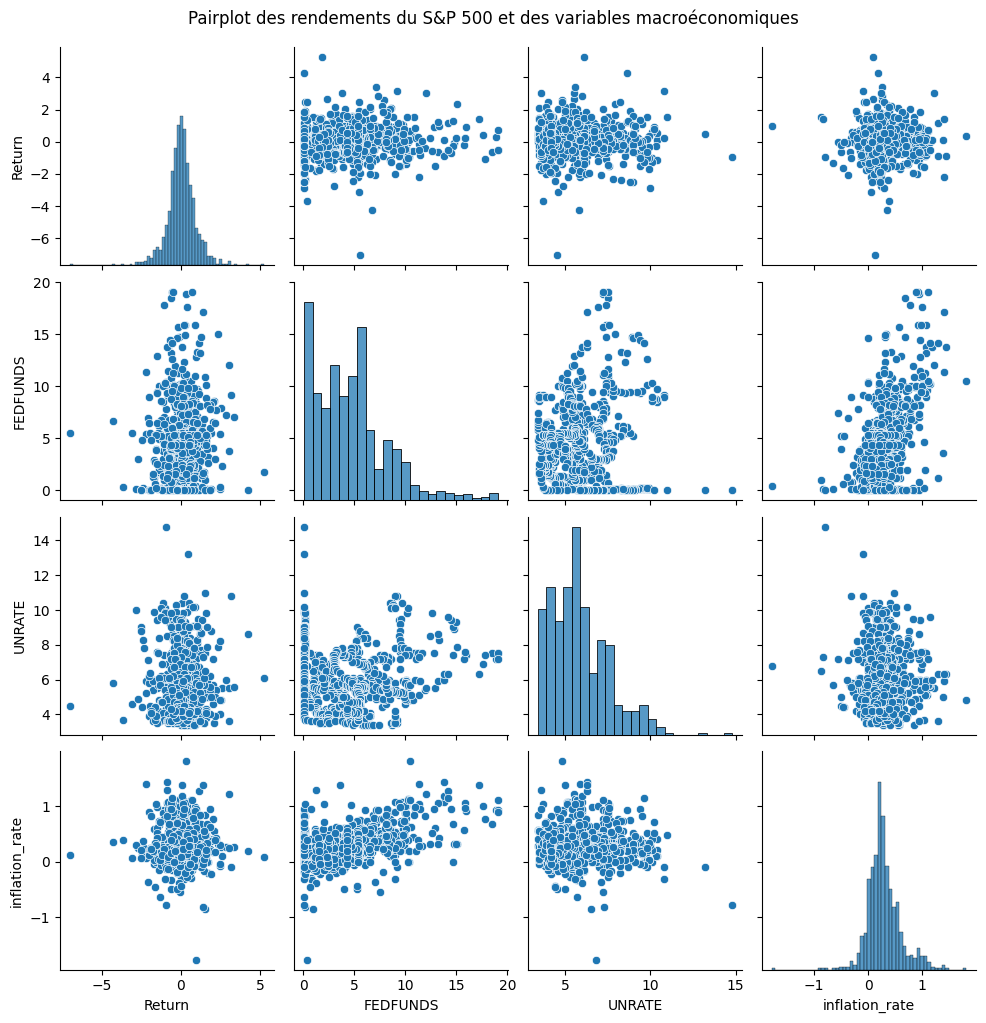

In [31]:
# Fusionner avec le rendement mensuel du S&P 500

datasp500 = pd.concat([sp500['Return'], macro_features], axis=1).dropna() # fusionner les données

print(datasp500['Return'].describe()) # statistiques descriptives du rendement du S&P 500

# Visualisation des données
sns.pairplot(datasp500)
plt.suptitle('Pairplot des rendements du S&P 500 et des variables macroéconomiques', y=1.02)
plt.show()


[iter 0] loss=1.3841 val_loss=0.0000 scale=1.0000 norm=0.9816
[iter 100] loss=1.1837 val_loss=0.0000 scale=1.0000 norm=0.8660
[iter 100] loss=1.1837 val_loss=0.0000 scale=1.0000 norm=0.8660
[iter 200] loss=1.1131 val_loss=0.0000 scale=2.0000 norm=1.6943
[iter 200] loss=1.1131 val_loss=0.0000 scale=2.0000 norm=1.6943
[iter 300] loss=1.0547 val_loss=0.0000 scale=1.0000 norm=0.8238
[iter 300] loss=1.0547 val_loss=0.0000 scale=1.0000 norm=0.8238
[iter 400] loss=1.0050 val_loss=0.0000 scale=1.0000 norm=0.8052
[iter 400] loss=1.0050 val_loss=0.0000 scale=1.0000 norm=0.8052
Mean Squared Error on Test Set: 0.5681
Mean Squared Error on Test Set: 0.5681


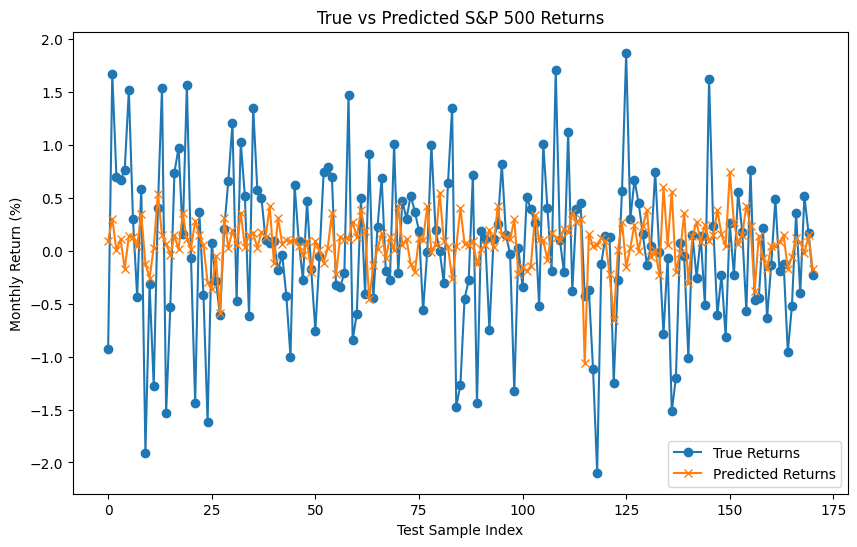

In [45]:
# Préparation des données pour la régression
X = datasp500.drop(columns=['Return']) # variables indépendantes
y = datasp500['Return'] # variable dépendante

# Division des données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Régression NGBoost
from ngboost import NGBoost
from ngboost.distns import Normal
ngb = NGBoost(Dist=Normal, n_estimators=500, learning_rate=0.01, verbose=True)
ngb.fit(X_train, y_train)
# Évaluation du modèle
from sklearn.metrics import mean_squared_error
y_pred = ngb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse:.4f}')
# Visualisation des prédictions
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='True Returns', marker='o')
plt.plot(y_pred, label='Predicted Returns', marker='x')
plt.title('True vs Predicted S&P 500 Returns')
plt.xlabel('Test Sample Index')
plt.ylabel('Monthly Return (%)')
plt.legend()
plt.show()

